In [283]:
from datasets import load_dataset, Audio
from IPython import display
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.ops.parametrizers import NonNegativeParametrizer
import matplotlib.pyplot as plt
import scipy as sp
from transformers import EncodecModel, AutoProcessor

In [273]:
dataset = load_dataset("danjacobellis/MYRiAD_V2",split='train[-20:]')
dataset = dataset.with_format("torch")
x = dataset[0]['acoustic']
x = x.to(torch.float).numpy()

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

In [274]:
for channel in range(12):
    display.display(display.Audio(x[channel],rate=48000))

(-0.02, 0.02)

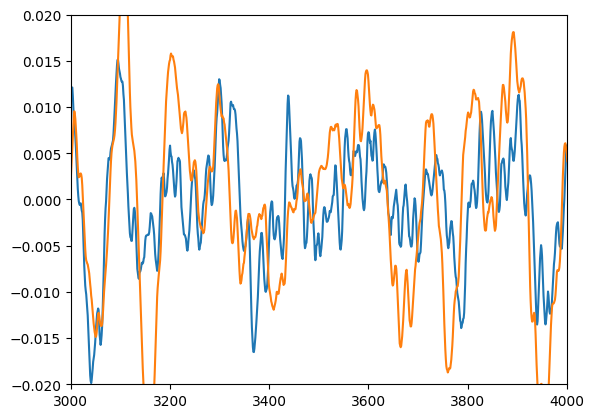

In [275]:
for channel in [0,6]:
    plt.plot(x[channel])
plt.xlim([3000,4000]);
plt.ylim([-0.02,0.02])

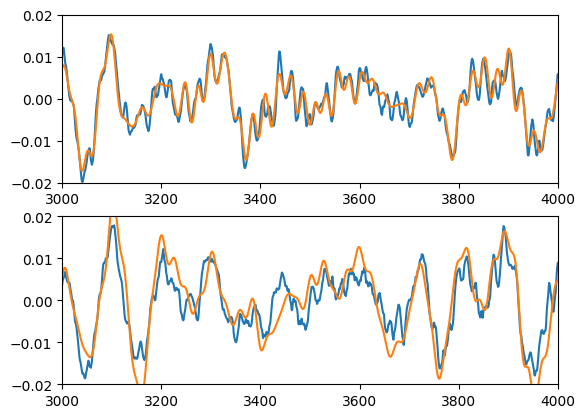

In [277]:
x0 = torch.unsqueeze(torch.tensor(x[0]),dim=0)
x6 = torch.unsqueeze(torch.tensor(x[6]),dim=0)
torchaudio.save
torchaudio.save('tmp.mp3',torch.cat([x0,x6]),sample_rate=48000,compression=8)
y = torchaudio.load('tmp.mp3')[0].numpy()
for channel in range(2):
    plt.subplot(2,1,channel+1)
    r = torch.tensor(sp.signal.correlate(x[channel],y[channel]))
    offset = y[channel].shape[0] - r.argmax() - 1
    plt.plot(x[channel])
    plt.plot(y[channel][offset:])
    plt.xlim([3000,4000])
    plt.ylim([-0.02,0.02])

In [229]:
model = EncodecModel.from_pretrained("facebook/encodec_48khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [278]:
audio_sample = torch.cat([x0,x6])
inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")
encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
audio_values = model(inputs["input_values"], inputs["padding_mask"]).audio_values
y = audio_values[0].detach().numpy()

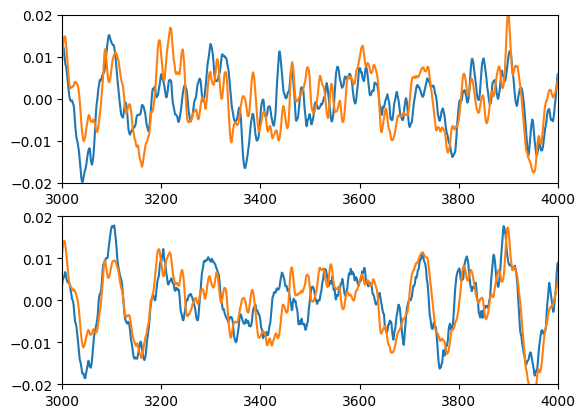

In [279]:
for channel in range(2):
    plt.subplot(2,1,channel+1)
    r = torch.tensor(sp.signal.correlate(x[channel],y[channel]))
    offset = y[channel].shape[0] - r.argmax() - 1
    plt.plot(x[channel])
    plt.plot(y[channel][offset:])
    plt.xlim([3000,4000])
    plt.ylim([-0.02,0.02])

In [286]:
class GDN_1d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        inverse: bool = False,
        beta_min: float = 1e-6,
        gamma_init: float = 0.1,
    ):
        super().__init__()

        beta_min = float(beta_min)
        gamma_init = float(gamma_init)
        self.inverse = bool(inverse)

        self.beta_reparam = NonNegativeParametrizer(minimum=beta_min)
        beta = torch.ones(in_channels)
        beta = self.beta_reparam.init(beta)
        self.beta = nn.Parameter(beta)

        self.gamma_reparam = NonNegativeParametrizer()
        gamma = gamma_init * torch.eye(in_channels)
        gamma = self.gamma_reparam.init(gamma)
        self.gamma = nn.Parameter(gamma)

    def forward(self, x: Tensor) -> Tensor:
        _, C, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1)
        norm = F.conv1d(x**2, gamma, beta)

        if self.inverse:
            norm = torch.sqrt(norm)
        else:
            norm = torch.rsqrt(norm)

        out = x * norm

        return out

def analysis_1d(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )

def synthesis_1d(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )

class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            analysis_1d(12, N),
            GDN_1d(N),
            analysis_1d(N, N),
            GDN_1d(N),
            analysis_1d(N, N),
        )

        self.decode = nn.Sequential(
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, 12),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [423]:
net = RateDistortionAutoEncoder()
checkpoint = torch.load("rdae_MYRiAD_V2_checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [424]:
x = dataset[0]['acoustic'].to(torch.float)
x = x.unsqueeze(0)
y = net(x)
x = x.detach().numpy()[0][[0,6]]
y = y[0].detach().numpy()[0][[0,6]]

In [425]:
z = (x-y)
x.max()/(z*z).mean()

657.5516

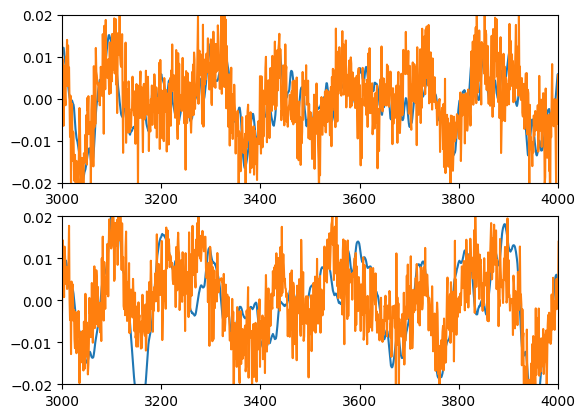

In [426]:
for channel in range(2):
    plt.subplot(2,1,channel+1)
    r = torch.tensor(sp.signal.correlate(x[channel],y[channel]))
    offset = y[channel].shape[0] - r.argmax() - 1
    plt.plot(x[channel])
    plt.plot(y[channel][offset:])
    plt.xlim([3000,4000])
    plt.ylim([-0.02,0.02])

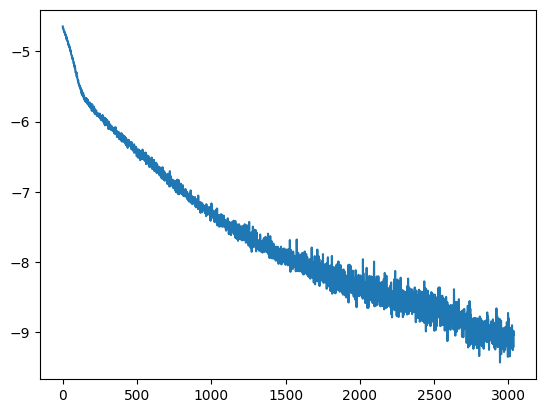

In [427]:
import numpy as np
distortion = np.load('distortion.npy')
plt.plot(np.log(distortion))